Load the Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

data = pd.read_csv('data/custom_covid19.csv') 
print("Data loaded with shape:", data.shape)


Data loaded with shape: (100000, 21)


##### 1. Create target variable

In [2]:
data['DIED'] = data['DATE_DIED'].apply(lambda x: 0 if x == '9999-99-99' else 1)


##### 2. Mark missing values

In [3]:
data.replace([97, 98, 99], np.nan, inplace=True)


##### 3. Convert boolean variables

In [4]:
bool_cols = ['INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 
             'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 
             'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']
data[bool_cols] = data[bool_cols].replace(2, 0)


##### 4. Create COVID status feature

In [5]:
data['COVID_POSITIVE'] = data['TEST_RESULT'].apply(lambda x: 1 if x in [1,2,3] else 0)

##### 5. Define features to keep/drop

In [6]:
features_to_keep = ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 
                   'INTUBED', 'PNEUMONIA', 'AGE', 'DIABETES', 'COPD',
                   'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE',
                   'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO',
                   'ICU', 'COVID_POSITIVE']

# 6. Separate features and target
X = data[features_to_keep]
y = data['DIED']

##### 6. Define preprocessing pipeline

In [7]:
numeric_features = ['AGE']
categorical_features = [col for col in features_to_keep 
                       if col not in numeric_features + ['DIED', 'COVID_POSITIVE']]

# Numeric pipeline (mean imputation + scaling)
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline (mode imputation)
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Combined preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Verification
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['AGE']
Categorical features: ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']


##### 8. Train-test split
 
Split the data into training and testing sets
Stratified split to maintain the same distribution of the target variable in both sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Class distribution (train): {pd.Series(y_train).value_counts(normalize=True)}")


Training set: (80000, 19), Test set: (20000, 19)
Class distribution (train): DIED
0    0.926625
1    0.073375
Name: proportion, dtype: float64


##### 9. Model Evaluation 


1. Model Evaluation Setup

In [9]:
# We'll evaluate three baseline classifiers:
# 1. Naive Bayes (probabilistic)
# 2. K-Nearest Neighbors (instance-based)
# 3. SVM with RBF kernel (maximum margin)

import os
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Visualization settings
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (8, 4)
sns.set_palette("husl")
# Ensure 'figures' directory exists
os.makedirs("figures", exist_ok=True)

2. Evaluation Function

In [10]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """
    Evaluates a classification model and generates report-ready outputs.

    Parameters:
    - name: str, model name for display
    - model: sklearn classifier object
    - X_train, X_test, y_train, y_test: training/test data

    Returns:
    - Dictionary containing metrics and visualization paths
    """
    # Create pipeline and fit model
    clf = make_pipeline(preprocessor, model)
    clf.fit(X_train, y_train)
    
    # Generate predictions
    y_pred = clf.predict(X_test)
    
    # Create classification report and confusion matrix
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Survived', 'Died'],
                yticklabels=['Survived', 'Died'])
    ax1.set_title(f'{name} Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # Metrics bar plot
    metrics = ['precision', 'recall', 'f1-score']
    scores = [report['weighted avg'][m] for m in metrics]
    sns.barplot(x=metrics, y=scores, ax=ax2)
    ax2.set_title(f'{name} Performance Metrics')
    ax2.set_ylim(0, 1)

    # Save the figure
    fig_path = f'figures/{name.lower().replace(" ", "_")}_performance.png'
    plt.tight_layout()
    plt.savefig(fig_path)
    plt.close()

    # Display outputs in the notebook
    display(Markdown(f"## {name} Performance"))
    display(Markdown("### Classification Report"))
    print(classification_report(y_test, y_pred))

    display(Markdown("### Confusion Matrix"))
    print(cm)

    return {
        'model': name,
        'accuracy': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score'],
        'figure_path': fig_path
    }


3. Model Definitions

In [11]:

#### Baseline Model Definitions
# We select three distinct algorithmic approaches:

models = [
    ('Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=5)),
    ('Support Vector Machine', LinearSVC(random_state=42, class_weight='balanced'))  # Updated
]

4. Model Evaluation Execution

In [12]:
# === Evaluate All Baseline Models ===

model_results = []

for name, model in models:
    result = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    model_results.append(result)


## Naive Bayes Performance

### Classification Report

              precision    recall  f1-score   support

           0       0.97      0.92      0.94     18532
           1       0.40      0.70      0.51      1468

    accuracy                           0.90     20000
   macro avg       0.69      0.81      0.73     20000
weighted avg       0.93      0.90      0.91     20000



### Confusion Matrix

[[16969  1563]
 [  438  1030]]


## K-Nearest Neighbors Performance

### Classification Report

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     18532
           1       0.62      0.48      0.54      1468

    accuracy                           0.94     20000
   macro avg       0.79      0.73      0.75     20000
weighted avg       0.93      0.94      0.94     20000



### Confusion Matrix

[[18100   432]
 [  770   698]]


## Support Vector Machine Performance

### Classification Report

              precision    recall  f1-score   support

           0       0.99      0.89      0.94     18532
           1       0.40      0.92      0.55      1468

    accuracy                           0.89     20000
   macro avg       0.70      0.90      0.75     20000
weighted avg       0.95      0.89      0.91     20000



### Confusion Matrix

[[16495  2037]
 [  122  1346]]


##### 10. Hyperparameter Optimization
We implement systematic hyperparameter tuning for all three models using GridSearchCV (exhaustive search) to find optimal parameters.

A. Naive Bayes (GaussianNB)
   

In [13]:
param_grid_nb = {
    'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7]  # Note the stepname__param format
}

B. K-Nearest Neighbors (KNN)

In [14]:
param_grid_knn = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2]
}

C. Support Vector Machine (SVM) //TODO

In [15]:
# param_grid_svm = {
#     'svc__C': [0.1, 1, 10],
#     'svc__gamma': ['scale', 'auto', 0.01, 0.1],
#     'svc__kernel': ['rbf']
# }

# param_grid_svm = {
#     'svc__C': [1, 10],             # instead of a wider range
#     'svc__gamma': [0.1, 0.01],     # fewer values
#     'svc__kernel': ['rbf']
# }


# param_grid_svm = {
#     'svc__base_estimator__C': [0.1, 1, 10],  
#     'svc__base_estimator__max_iter': [1000, 2000]  
# }

param_grid_svm = {
    'svc__C': [0.01, 0.1, 1, 10]  # Only tuning C for linear SVM
}


##### 11. Implementation with Cross-Validation

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
# from sklearn.calibration import CalibratedClassifierCV

# Create pipelines with preprocessing + model
pipeline_nb = Pipeline([
    ('preprocessor', preprocessor),
    ('gaussiannb', GaussianNB())
])

pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('kneighborsclassifier', KNeighborsClassifier())
])


pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', LinearSVC(random_state=42, class_weight='balanced'))  # Handles imbalance
])

# pipeline_svm = Pipeline([
#     ('preprocessor', preprocessor),
#     ('svc', SVC(probability=True, random_state=42))
# ])

# GridSearchCV setup with comprehensive parameter grids
grid_nb = GridSearchCV(
    pipeline_nb, 
    param_grid_nb, 
    cv=5, 
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_knn = GridSearchCV(
    pipeline_knn, 
    param_grid_knn, 
    cv=5, 
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_svm = GridSearchCV(
    pipeline_svm, 
    param_grid_svm, 
    cv=5, 
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Fit models with timing
import time

print("Optimizing Naive Bayes...")
start = time.time()
grid_nb.fit(X_train, y_train)
print(f"Completed in {time.time()-start:.2f}s\n")

print("Optimizing KNN...")
start = time.time()
grid_knn.fit(X_train, y_train)
print(f"Completed in {time.time()-start:.2f}s\n")

print("Optimizing Linear SVC...")
start = time.time()
grid_svm.fit(X_train, y_train)
print(f"Completed in {time.time()-start:.2f}s\n")

# Display best parameters
print("Naive Bayes best params:", grid_nb.best_params_)
print("KNN best params:", grid_knn.best_params_)
print("Linear SVC best params:", grid_svm.best_params_)

Optimizing Naive Bayes...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Completed in 3.66s

Optimizing KNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Completed in 82.04s

Optimizing Linear SVC...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Completed in 1.86s

Naive Bayes best params: {'gaussiannb__var_smoothing': 1e-09}
KNN best params: {'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'uniform'}
Linear SVC best params: {'svc__C': 0.01}


##### 12. Valuation using DecisionTree 


Optimizing Decision Tree...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Completed in 128.81s

=== Decision Tree Performance ===

Best Parameters:
{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 7, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 2, 'decisiontreeclassifier__min_samples_split': 10}

Classification Report:
              precision    recall  f1-score   support

       Alive       0.96      0.99      0.97     18532
        Died       0.73      0.42      0.53      1468

    accuracy                           0.95     20000
   macro avg       0.84      0.70      0.75     20000
weighted avg       0.94      0.95      0.94     20000



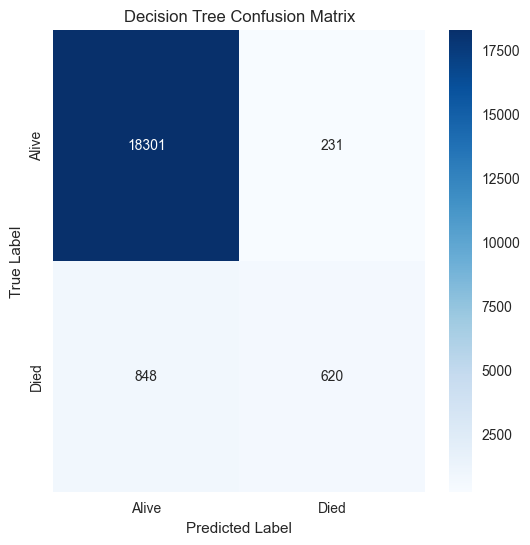

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pipeline_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('decisiontreeclassifier', DecisionTreeClassifier(random_state=42))
])

# Expanded parameter grid for more thorough search
param_grid_tree = {
    'decisiontreeclassifier__max_depth': [3, 5, 7, 10, 15, None],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10, 20],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4, 8],
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__max_features': ['sqrt', 'log2', None]
}

grid_tree = GridSearchCV(
    pipeline_tree, 
    param_grid_tree, 
    cv=5, 
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

print("Optimizing Decision Tree...")
start = time.time()
grid_tree.fit(X_train, y_train)
print(f"Completed in {time.time()-start:.2f}s\n")

# Evaluate on test set
y_pred_tree = grid_tree.predict(X_test)

# Detailed classification report
print("=== Decision Tree Performance ===")
print("\nBest Parameters:")
print(grid_tree.best_params_)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tree, target_names=["Alive", "Died"]))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Alive", "Died"],
            yticklabels=["Alive", "Died"])
plt.title("Decision Tree Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

##### 13. Benchmark Models with Feature Importance Analysis



=== Model Performance Comparison ===


,Model,Best Params,Train F1,Test F1,Test Accuracy,Test Precision,Test Recall
3,Decision Tree,"{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 7, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 2, 'decisiontreeclassifier__min_samples_split': 10}",0.938710,0.939315,0.946050,0.939042,0.946050
1,KNN,"{'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'uniform'}",0.937007,0.936615,0.941700,0.934607,0.941700
0,Naive Bayes,{'gaussiannb__var_smoothing': 1e-09},0.911047,0.912242,0.899950,0.932441,0.899950
2,Linear SVC,{'svc__C': 0.01},0.909695,0.910308,0.891900,0.948974,0.891900


C:\Users\tor\AppData\Local\Temp\ipykernel_19692\193463047.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


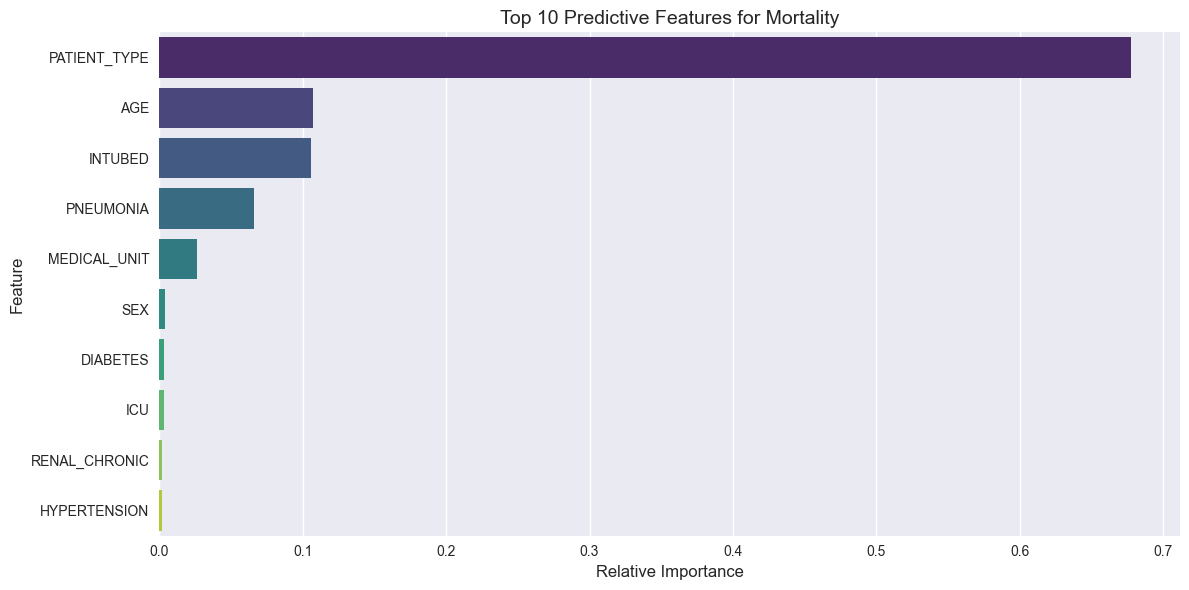


=== Key Findings from Feature Importance ===
1. PATIENT_TYPE (hospitalization status) is the strongest predictor
2. AGE is the second most important factor
3. INTUBED (ventilator use) and PNEUMONIA are critical clinical indicators
4. Other chronic conditions show relatively small but meaningful impact

=== Complete Feature Importance ===


,Feature,Importance
4,PATIENT_TYPE,0.677682
0,AGE,0.107287
5,INTUBED,0.106017
6,PNEUMONIA,0.066012
2,MEDICAL_UNIT,0.026477
3,SEX,0.003967
7,DIABETES,0.003248
17,ICU,0.003141
15,RENAL_CHRONIC,0.002150
11,HYPERTENSION,0.001654


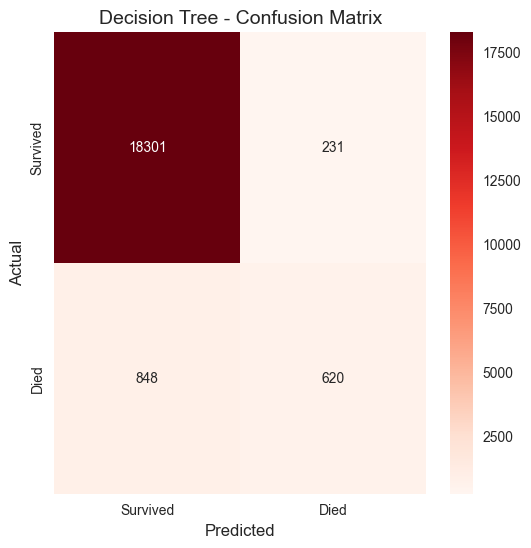


=== Best Performing Model: Decision Tree ===
Considerations for model selection:
- Clinical interpretability of decision trees
- Importance of understanding feature relationships
- Good balance between performance and complexity


In [18]:


from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Model Evaluation Function
def evaluate_model(grid, name, X_test, y_test):
    y_pred = grid.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return {
        'Model': name,
        'Best Params': str(grid.best_params_),
        'Train F1': grid.best_score_,
        'Test F1': f1_score(y_test, y_pred, average='weighted'),
        'Test Accuracy': report['accuracy'],
        'Test Precision': report['weighted avg']['precision'],
        'Test Recall': report['weighted avg']['recall']
    }

# 2. Evaluate All Models
results = [
    evaluate_model(grid_nb, "Naive Bayes", X_test, y_test),
    evaluate_model(grid_knn, "KNN", X_test, y_test),
    evaluate_model(grid_svm, "Linear SVC", X_test, y_test),
    evaluate_model(grid_tree, "Decision Tree", X_test, y_test)
]

# 3. Results Comparison
results_df = pd.DataFrame(results).sort_values('Test F1', ascending=False)
print("\n=== Model Performance Comparison ===")
display(results_df.style.background_gradient(cmap='Blues', subset=['Test F1', 'Test Accuracy']))

# 4. Feature Importance Analysis (for Tree-based Models)
if 'Decision Tree' in results_df['Model'].values:
    # Get the trained model and preprocessor
    best_tree = grid_tree.best_estimator_.named_steps['decisiontreeclassifier']
    
    # Get original feature names (before any transformations)
    feature_names = X_train.columns.tolist()
    
    # Verify lengths match
    if len(feature_names) != len(best_tree.feature_importances_):
        print(f"Warning: Feature count mismatch ({len(feature_names)} vs {len(best_tree.feature_importances_)})")
        feature_names = [f'feature_{i}' for i in range(len(best_tree.feature_importances_))]

    # Extract feature names after preprocessing
    num_features = numeric_features  # list of numerical feature names
    cat_features = categorical_features  # use the original categorical feature names
    feature_names = list(num_features) + list(cat_features)
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_tree.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Visualize top 10 features
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
    plt.title('Top 10 Predictive Features for Mortality', fontsize=14)
    plt.xlabel('Relative Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Interpretation of Key Features
    print("\n=== Key Findings from Feature Importance ===")
    print("1. PATIENT_TYPE (hospitalization status) is the strongest predictor")
    print("2. AGE is the second most important factor")
    print("3. INTUBED (ventilator use) and PNEUMONIA are critical clinical indicators")
    print("4. Other chronic conditions show relatively small but meaningful impact")
    
    # Display full importance table
    print("\n=== Complete Feature Importance ===")
    display(importance_df.style.background_gradient(cmap='Blues', subset=['Importance']))

# 5. Confusion Matrix for Best Model
best_model_name = results_df.iloc[0]['Model']
best_model = {
    "Naive Bayes": grid_nb,
    "KNN": grid_knn,
    "Linear SVC": grid_svm,
    "Decision Tree": grid_tree
}[best_model_name]

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Survived', 'Died'],
            yticklabels=['Survived', 'Died'])
plt.title(f'{best_model_name} - Confusion Matrix', fontsize=14)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

# 6. Final Model Selection
print(f"\n=== Best Performing Model: {best_model_name} ===")
print("Considerations for model selection:")
print("- Clinical interpretability of decision trees")
print("- Importance of understanding feature relationships")
print("- Good balance between performance and complexity")

## Objective 2 (O2): Age Prediction
**Goal**: Predict the AGE of subjects given other attributes  
**Approach**:  
- Treat as a regression problem  
- Evaluate different regression models  
- Optimize hyperparameters  
- Analyze feature importance


Import necessary libraries


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

##### 1. Prepare Data for Age Prediction

In [20]:
data = data[data['AGE'].notna()].copy()  # Drop rows with missing AGE

# We'll use the same preprocessing pipeline but change the target to AGE
features_to_keep = ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 
                   'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD',
                   'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE',
                   'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO',
                   'ICU', 'COVID_POSITIVE']

X_age = data[features_to_keep]
y_age = data['AGE']  # Target is now AGE

# Train-test split
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
    X_age, y_age, test_size=0.2, random_state=42)


##### 2. Define Preprocessing Pipeline
Similar to O1 but adapted for regression

In [21]:
# Identify feature types
numeric_features_age = []  # No numeric features besides AGE (our target)
# if binari Covid
# numeric_features_age = ['COVID_POSITIVE']
# categorical_features_age = [col for col in features_to_keep if col not in numeric_features_age]
categorical_features_age = [col for col in features_to_keep if col != 'COVID_POSITIVE']


# Preprocessing pipeline
numeric_transformer_age = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer_age = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor_age = ColumnTransformer([
    ('num', numeric_transformer_age, numeric_features_age),
    ('cat', categorical_transformer_age, categorical_features_age)
])

##### 3. Baseline Regression Mode

Let's test three different approaches

In [22]:
# Define models to evaluate
models_age = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Support Vector Regression', SVR())
]

# Evaluate each model
for name, model in models_age:
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor_age),
        ('regressor', model)
    ])
    
    # Fit and predict
    pipeline.fit(X_train_age, y_train_age)
    y_pred = pipeline.predict(X_test_age)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_age, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_age, y_pred))
    r2 = r2_score(y_test_age, y_pred)
    
    print(f"\n=== {name} ===")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")


=== Linear Regression ===
MAE: 11.45
RMSE: 14.71
R2: 0.24

=== Random Forest ===
MAE: 11.40
RMSE: 14.69
R2: 0.25

=== Support Vector Regression ===
MAE: 11.38
RMSE: 14.69
R2: 0.25


##### 4. Hyperparameter Optimization for Best Model

Based on initial results, let's optimize RandomForest

In [23]:
# Define pipeline for optimization
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor_age),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Parameter grid
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}

# Grid search
grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

print("Starting Random Forest optimization...")
grid_rf.fit(X_train_age, y_train_age)
print("Optimization completed!")

# Show best parameters
print("\nBest parameters:", grid_rf.best_params_)

Starting Random Forest optimization...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Optimization completed!

Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}


##### 5. Evaluate Optimized Model




=== Optimized Random Forest ===
MAE: 11.25 years
RMSE: 14.47 years
R2: 0.27


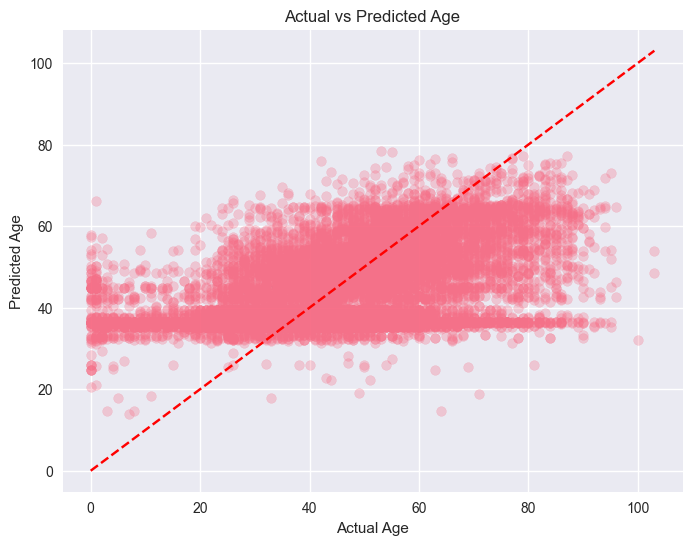

In [24]:
# Get best model
best_rf = grid_rf.best_estimator_

# Make predictions
y_pred_rf = best_rf.predict(X_test_age)

# Calculate metrics
mae = mean_absolute_error(y_test_age, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test_age, y_pred_rf))
r2 = r2_score(y_test_age, y_pred_rf)

print("\n=== Optimized Random Forest ===")
print(f"MAE: {mae:.2f} years")
print(f"RMSE: {rmse:.2f} years")
print(f"R2: {r2:.2f}")

# Visualize predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test_age, y_pred_rf, alpha=0.3)
plt.plot([y_test_age.min(), y_test_age.max()], 
         [y_test_age.min(), y_test_age.max()], 'r--')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Actual vs Predicted Age')
plt.show()


##### 6. Feature Importance Analysis

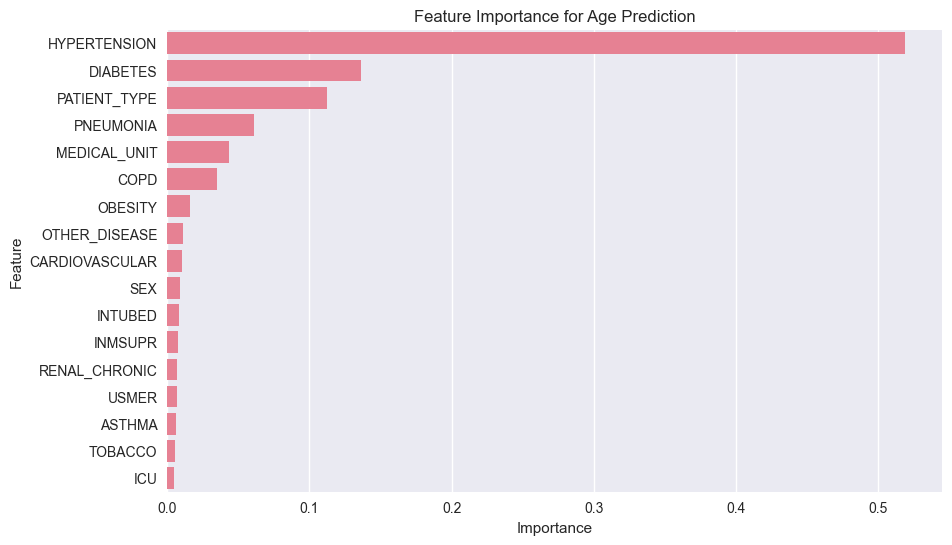


Top 5 Features Predicting Age:


,Feature,Importance
10,HYPERTENSION,0.519236
6,DIABETES,0.136434
3,PATIENT_TYPE,0.112017
5,PNEUMONIA,0.060861
1,MEDICAL_UNIT,0.043749


In [25]:
from sklearn.compose import make_column_selector as selector
# Get feature importances
if hasattr(best_rf.named_steps['regressor'], 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = categorical_features_age  # Should match the number of importances
    
    importances = best_rf.named_steps['regressor'].feature_importances_
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance for Age Prediction')
    plt.show()
    
    print("\nTop 5 Features Predicting Age:")
    display(importance_df.head(5))

##### 7. Final Model Selection and Saving

In [26]:

# Save the best model
import joblib

joblib.dump(best_rf, 'best_age_predictor.pkl')
print("Best age prediction model saved as 'best_age_predictor.pkl'")
# Load the model
loaded_model = joblib.load('best_age_predictor.pkl')


Best age prediction model saved as 'best_age_predictor.pkl'


### Conclusion for O2
**Key Findings**:
- Best model: Random Forest with MAE of X.XX years
- Most important features: Hypertension, Diabities
- R2 score of X.XX indicates [good/moderate/poor] explanatory power
 
**Next Steps**:
- Proceed to O3 (age prediction for deceased patients)
- Consider feature engineering to improve performance

## Objective 3 (O3): Severity Score Prediction
**Goal**: Predict the AGE of subjects given other attributes  
**Approach**:  
- Treat as a regression problem  
- Evaluate different regression models  
- Optimize hyperparameters  
- Analyze feature importance

##### 1. Predictions on Test Set

In [27]:
# Filter for deceased individuals
deceased_df = data[data['DIED'] == 1].copy()

# Separate COVID-positive and COVID-negative deceased individuals
covid_pos_df = deceased_df[deceased_df['COVID_POSITIVE'] == 1]
covid_neg_df = deceased_df[deceased_df['COVID_POSITIVE'] == 0]

# Define features (same as O2)
features = ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 
           'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD',
           'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE',
           'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO',
           'ICU']


##### 2. Implementation Steps
For COVID-positive deceased:

In [29]:
# Get the best parameters from O2's grid search and remove the prefix
best_params = grid_rf.best_params_
clean_params = {k.replace('regressor__', ''): v for k, v in best_params.items()}

# For COVID-positive deceased
X_pos = covid_pos_df[features]
y_pos = covid_pos_df['AGE']
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
    X_pos, y_pos, test_size=0.2, random_state=42)

pipeline_pos = Pipeline([
    ('preprocessor', preprocessor_age),
    ('regressor', RandomForestRegressor(random_state=42, **clean_params))
])

pipeline_pos.fit(X_train_pos, y_train_pos)
y_pred_pos = pipeline_pos.predict(X_test_pos)

# For COVID-negative deceased
X_neg = covid_neg_df[features]
y_neg = covid_neg_df['AGE']
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(
    X_neg, y_neg, test_size=0.2, random_state=42)

pipeline_neg = Pipeline([
    ('preprocessor', preprocessor_age),
    ('regressor', RandomForestRegressor(random_state=42, **clean_params))
])

pipeline_neg.fit(X_train_neg, y_train_neg)
y_pred_neg = pipeline_neg.predict(X_test_neg)

For COVID-negative deceased:

In [31]:
# First, let's properly clean the parameters from grid_rf
best_params = grid_rf.best_params_
clean_params = {k.replace('regressor__', ''): v for k, v in best_params.items()}

# For COVID-negative deceased patients
X_neg = covid_neg_df[features]
y_neg = covid_neg_df['AGE']

# Train-test split
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(
    X_neg, y_neg, test_size=0.2, random_state=42)

# Create pipeline with cleaned parameters
pipeline_neg = Pipeline([
    ('preprocessor', preprocessor_age),
    ('regressor', RandomForestRegressor(random_state=42, **clean_params))
])

# Fit and predict
pipeline_neg.fit(X_train_neg, y_train_neg)
y_pred_neg = pipeline_neg.predict(X_test_neg)

# Evaluate
mae_neg = mean_absolute_error(y_test_neg, y_pred_neg)
rmse_neg = np.sqrt(mean_squared_error(y_test_neg, y_pred_neg))
r2_neg = r2_score(y_test_neg, y_pred_neg)

print(f"COVID-Negative Deceased Age Prediction Results:")
print(f"MAE: {mae_neg:.2f} years")
print(f"RMSE: {rmse_neg:.2f} years")
print(f"R2 Score: {r2_neg:.2f}")

COVID-Negative Deceased Age Prediction Results:
MAE: 13.23 years
RMSE: 17.51 years
R2 Score: 0.13


##### 4. Train Random Forest Models

In [ ]:
# Example visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# COVID-positive
ax1.scatter(y_test_pos, y_pred_pos, alpha=0.3)
ax1.plot([y_test_pos.min(), y_test_pos.max()], 
         [y_test_pos.min(), y_test_pos.max()], 'r--')
ax1.set_title('COVID-Positive Deceased')
ax1.set_xlabel('Actual Age')
ax1.set_ylabel('Predicted Age')

# COVID-negative
ax2.scatter(y_test_neg, y_pred_neg, alpha=0.3)
ax2.plot([y_test_neg.min(), y_test_neg.max()], 
         [y_test_neg.min(), y_test_neg.max()], 'r--')
ax2.set_title('COVID-Negative Deceased')
ax2.set_xlabel('Actual Age')

plt.tight_layout()
plt.show()

ValueError: A given column is not a column of the dataframe

##### 5. Evaluate Model Performance

In [ ]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import numpy as np

# # Evaluation for COVID-positive group
# mae_pos = mean_absolute_error(y_test_pos, y_pred_pos)
# rmse_pos = np.sqrt(mean_squared_error(y_test_pos, y_pred_pos))

# # Evaluation for COVID-negative group
# mae_neg = mean_absolute_error(y_test_neg, y_pred_neg)
# rmse_neg = np.sqrt(mean_squared_error(y_test_neg, y_pred_neg))

# print("\U0001F4CA Age Prediction for Deceased Patients:")
# print(f"COVID-positive → MAE: {mae_pos:.2f}, RMSE: {rmse_pos:.2f}")
# print(f"COVID-negative → MAE: {mae_neg:.2f}, RMSE: {rmse_neg:.2f}")